# Proyecto Semestral: Hito I

In [25]:
# install.packages("plotly")
# install.packages("curl")
# install.packages("openssl")
# install.packages("httr")
library(plotly)

ERROR: Error in library(plotly): there is no package called ‘plotly’


In [11]:
library(plotly)

ERROR: Error in library(plotly): there is no package called ‘plotly’


## Importar librerías

In [6]:
library(ggplot2)
# install.packages("corrgram")
library(corrgram)
# library(GGally)
# install.packages("dplyr")
library(dplyr)
# install.packages("reshape")
library(reshape)
# install.packages("plotly")
library(plotly)

ERROR: Error in library(plotly): there is no package called ‘plotly’


## Importa base de datos

Para el proyecto se utilizará un set de datos basado en la demanda de reserva en ciertos hoteles. Estos datos fueron extraídos desde la página kaggle. Estos contienen información con respecto a la reservación de hoteles, ya sea resort o en la ciudad durante los años 2015-2017. Entre la información incluida se tiene la fecha en la que fue hecha la reservación, el tiempo de estadía, la distribución de los clientes que reservan ( el número de adultos, niños y bebés) y el número de estacionamientos disponibles, entre otras cosas.
  

In [34]:
df = read.table(file = 'https://raw.githubusercontent.com/sebastianflp/DataMiningDCC/main/hotel_bookings.csv', as.is = F, sep = ',', header = TRUE)
head(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,⋯,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<int>,<int>,<fct>,<fct>
1,Resort Hotel,0,342,2015,July,27,1,0,0,2,⋯,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,737,2015,July,27,1,0,0,2,⋯,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
3,Resort Hotel,0,7,2015,July,27,1,0,1,1,⋯,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,13,2015,July,27,1,0,1,1,⋯,No Deposit,304,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,⋯,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,14,2015,July,27,1,0,2,2,⋯,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03


### Reemplazo de valores nulos
En la base de datos existen valores indefinidos escritos como string. Por lo que estas celdas se reemplazan con NA's, con el fin de facilitar su tratamiento.

In [ ]:
df$meal[df$meal == 'Undefined'] = NA
df$country[df$country == 'NULL'] = NA
df$market_segment[df$market_segment == 'Undefined'] = NA
df$distribution_channel[df$distribution_channel == 'Undefined'] = NA
df$agent[df$agent == 'NULL'] = NA
df$company[df$company == 'NULL'] = NA

### Motivación del Proyecto

Considerando los datos anteriormente expuestos sería de interés utilizarlos para poder predecir o calcular la probabilidad de que una persona cualquiera termine cancelando su reservación y así generar un perfil de este tipo de personas con el objetivo de poder ofrecerle reagendar o alguna solución que permita mantener al cliente interesado en utilizar este servicio y así reducir pérdidas.

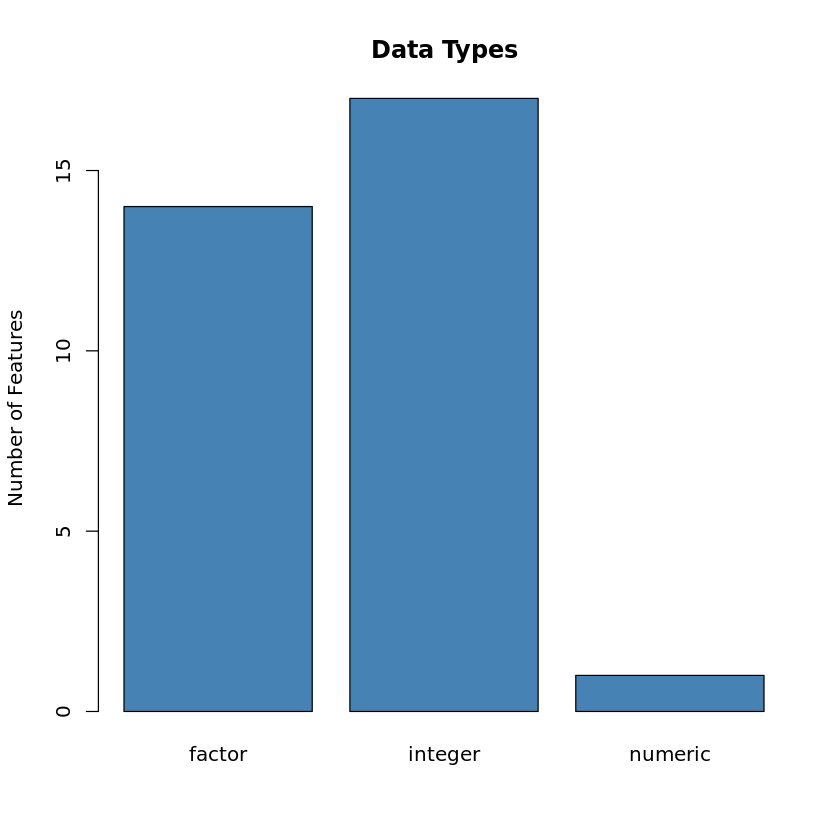

In [ ]:
data_types <- function(frame) {
  res <- lapply(frame, class)
  res_frame <- data.frame(tipo=unlist(res))
  # res_frame <- res_frame %>% group_by(tipo) %>% summarise(n=n())
  # ggplot(res_frame) + geom_bar(aes(x = tipo, y = n), stat = "identity") + theme(aspect.ratio = 0.4)
  barplot(table(res_frame), main="Data Types", col="steelblue", ylab="Number of Features")
}
data_types(df)

En la grafica anterior se puede apreciar la distribución en los tipo de las categorías siendo predominantes las de tipo "integer"

## Análisis exploratorio de datos

A continuación analizaremos el conjunto de datos usando técnicas de análisis exploratorio de datos. El objetivo es encontrar características relevantes que puedan afectar el desarrollo del proyecto y/o la validación de nuestra hipótesis. Primero, contemos el número de filas y columnas:

In [ ]:
dim(df)

[1] 119390     32

En total son 119.390 filas y 32 columnas. Nos gustaría poder estudiar el comportamiento de dichas variables, para esto haremos un $\textit{summary}$  de las más relevantes para el análisis.

In [ ]:
summary(df %>% select(company, children, country, agent, reservation_status, is_canceled))

En específico, en la siguiente celda se muestran las variables que presentan valores perdidos o nulos

In [ ]:
# tmp = sapply(df, function(x) sum(is.na(x)))
df_na = data.frame(variable=names(tmp),conteo=tmp)
row.names(df_na) = NULL
head(df_na[order(desc(df_na$conteo)),], 7)

# ggplot(df_na[df_na$conteo > 0,]) +
# geom_bar(aes(x = variable, y = conteo), stat = "identity") +
# coord_flip()

,variable,conteo
,<chr>,<int>
25,company,112593
24,agent,16340
13,meal,1169
14,country,488
16,distribution_channel,5
11,children,4
15,market_segment,2


Notemos que la variable $\textit{company}$ tiene casi $94,3\%$ de sus filas en NULL. Esto da motivos para no considerar esta columna debido a la cantidad de valores faltantes. Además, la columna children, que nos dice cuantos niños son considerados dentro de la reserva tiene 4 valores NA, también faltantes.

### Transforma a factores, numéricos y fechas
Para poder visualizar de manera correcta los datos, se debe formatear algunas variables que no encajan con sus descripciones correpondientes.

In [ ]:
df$is_canceled = as.factor(df$is_canceled)
df$arrival_date_day_of_month = as.factor(df$arrival_date_day_of_month)
df$arrival_date_week_number = as.factor(df$arrival_date_week_number)
df$reservation_status_date = as.Date(df$reservation_status_date)
df$is_repeated_guest = as.factor(df$is_repeated_guest)
df$agent = as.numeric(df$agent)
df$agent = as.factor(df$agent)
df$company = as.numeric(df$company)

### ¿Está balanceada la variable de interés?

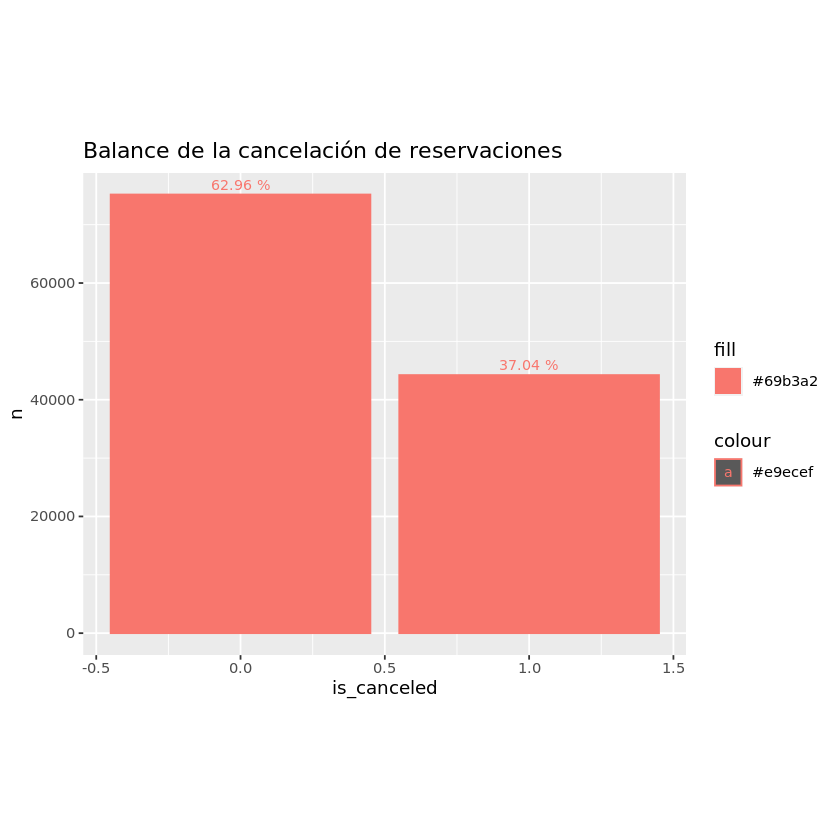

In [103]:
df_bal = df %>% group_by(is_canceled) %>% summarise(n=n())
df_bal["perc"] = paste(as.character(round(df_bal$n / sum(df_bal$n) * 100, 2)), "%")
ggplot(df_bal, aes(x=is_canceled, y=n, fill="#69b3a2", color="#e9ecef"))+
    geom_col()+
    ggtitle("Balance de la cancelación de reservaciones")+
    geom_text(label=c(df_bal$perc), vjust=-0.5, size=3)+theme(aspect.ratio = 0.8)
ggsave(filename = 'hola', device = svg,width = 10, height = 10)

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


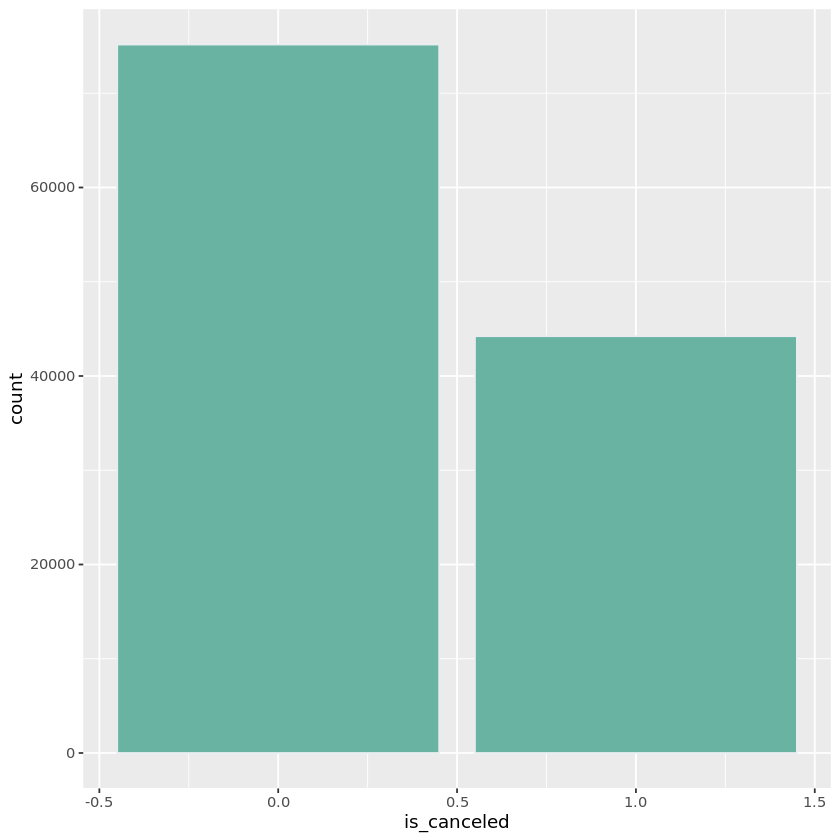

In [62]:
p <- ggplot(df) + geom_histogram(aes(x=is_canceled), fill="#69b3a2", color="#e9ecef", alpha=1, stat="count")
p

In [ ]:
n = nrow(df)
n_1 = nrow(df[df$is_canceled == 1,])
n_0 = n - n_1

100 * n_1 / n
100 * n_0 / n

[1] 37.04163

[1] 62.95837

Notemos que hay una diferencia significativa entre ambos datos

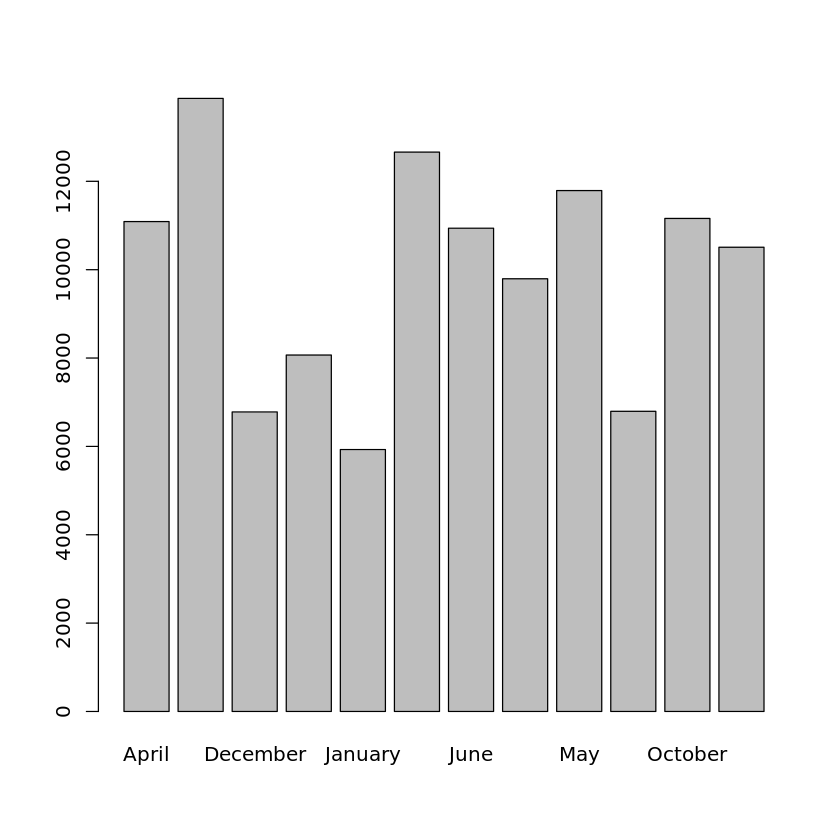

In [ ]:
plot(df$arrival_date_month)

distribucion de reservas por mes

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e23c1f0e-bfe3-498a-84d7-0763e07e74ab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>